# GZK horizon visualisation

Assuming the continuous loss approximation for UHE proton propagation and typical detection uncertainties described in the paper, we can try to visualise what this means. We have a kind of *effective GZK horizon* for each particle, depending on its energy and the detection uncertainties. See Section 2.6 for details. We want to be able to plot the following:

$$
P(x, z | E, \omega, \rm{detected}),
$$
i.e. where the UHECR could have come from if we detect it with energy $E$ and direction $\omega$.
<br>
<br>
*This code was used to make Figures 4 and 5 in Capel & Mortlock (2019).*

In [12]:
import numpy as np
import h5py
from scipy import interpolate

import stan_utility
from fancy.propagation.energy_loss import get_Eth_src
from horizon_visualisation import P_x_z, HPD_contours

In [26]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
plt.style.use(['minimalist'])
plt.style.use(['minimalist']) # to match paper style

# Colours
darkblue = '#114A56'
midblue = '#1A7282'
lightblue = '#6DA5AF'
lightpurple = '#875F74'
purple = '#592441'

## Calculation

If we **ignore detection uncertainties**, it is possible to find an analytical expression for the above probability (see Equation 13). We plot this here by interpolating over a precomputed grid of values. 

### Precomputing $E_\rm{src}$ and $E_\rm{arr}$
These cells show how the files in `output/` have been computed. These computations can be re-run, but the output files are also provided with this code, so it is possible to skip ahead to the next subsection. 

In [ ]:
# Select representative energies
selected_E = [50, 70] # EeV

# Precompute the equivalent source energies 
# for a range of propagation distances
# (this takes a while... ~10 min)
D = np.linspace(0, 500, 100) # Mpc
Esrc = [get_Eth_src(E, D) for E in selected_E] # EeV

# Write to a file to save time in future 
with h5py.File('output/precomp_Esrc.h5', 'w') as f:
    f.create_dataset('selected_E', data = selected_E)
    f.create_dataset('Esrc', data = Esrc)
    f.create_dataset('D', data = D)

In [ ]:
# We also want to calculate the arrival energies 
# for a range of source energies and distances.
# This is done with an MPI script on XX cores.
# $ mpirun -n XX python precomp_Earr.py

### Read precomputed values

In [2]:
with h5py.File('output/precomp_Esrc.h5', 'r') as f:
    D = f['D'].value
    Esrc = f['Esrc'].value
    
with h5py.File('output/precomp_Earr.h5', 'r') as f:
    Earr_grid = f['Earr_grid'].value
    D_grid = f['D_grid'].value
    E_grid = f['E_grid'].value

### Figure 4 (top panel)

For calculation, see `horizon_visualisation.py`.

In [6]:
# Set parameters
alpha = 2
B = 1 # nG

# Unpack for readability 
Esrc_50 = Esrc[0]
Esrc_70 = Esrc[1]

In [7]:
# Calculate P(x, z | E omega) on a meshgrid of x, z
# Takes ~ 10s
xl = np.linspace(0, 100, 300) # Mpc
zl = np.linspace(0, 400, 300) # Mpc
z, x = np.meshgrid(zl, xl)

P_x_z_50 = P_x_z(z, x, Esrc_50, D_grid, E_grid, Earr_grid, B, alpha)
P_x_z_70 = P_x_z(z, x, Esrc_70, D_grid, E_grid, Earr_grid, B, alpha)

In [22]:
# Get HPD contours or tail regions to show shape
levels = [0.99999, 0.99995, 0.9999, 0.999]
l50 = HPD_contours(np.nan_to_num(P_x_z_50), levels)
levels = [0.99997, 0.9999, .9995, 0.999]
l70 = HPD_contours(np.nan_to_num(P_x_z_70), levels)

# Prepare legend
legend_elements = [Line2D([0], [0], color = lightpurple, linestyle = ':', 
                          label = '$E = 50$ EeV', linewidth = 1.5), 
                  Line2D([0], [0], color = purple, label = '$E = 70$ EeV', 
                         linewidth = 1.5)]

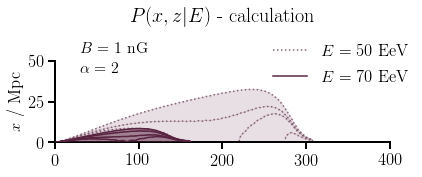

In [25]:
# Plot 
fig, ax = plt.subplots()
fig.set_size_inches((6, 0.25 * 6)) # hold aspect ratio

# Contour plots
ax.contour(zl, xl, P_x_z_70, l70, colors = purple, linewidths = 1.5, zorder = 3)
ax.contour(zl, xl, P_x_z_50, l50, colors = lightpurple, 
           linewidths = 1.5, linestyles = ':', zorder = 2)
ax.contourf(z, x, P_x_z_70, l70, extend = 'max', 
             alpha = 0.5, colors = purple, zorder = 3)
ax.contourf(z, x, P_x_z_50, l50, extend = 'max', 
             alpha = 0.2, colors = lightpurple, zorder = 2)

# Annotation
ax.set_ylabel(r'$x$ / Mpc')
ax.set_title(r'$P(x, z | E)$ - calculation', y = 1.4)
ax.set_xlim(0, 400)
ax.set_ylim(0, 50)
ax.text(30, 42.5, 
         '$B = 1$ nG \n $\\alpha = 2$', fontsize = 16)
ax.legend(handles = legend_elements, bbox_to_anchor = (1.1, 1.4));

## Simulation

In order to **include the detection uncertainties**, we run a simulation of the UHECR propagation. For consistency, we use the same <tt>Stan</tt> functions that are called in the fit (see `stan/uhecr_propagation.stan`).    

In [ ]:
model = stan_utility.compile_model('../stan/horizon_visualisation.stan', include_paths = '../../../stan/')

In [ ]:
inputs = {'varpi' : [0, 0, 1], 
          'alpha' : 2, 
          'Eth' : 20, 
          'Eerr' : 0.12, # import from fancy.Auger
          'N' : int(1E2), 
          'B' : 1, 
          'kappa_c' : 9000} # change to value quoted in paper? import from fancy/Auger?

simulation = model.sampling(data = inputs, iter = 1, chains = 1, 
                            algorithm = "Fixed_param", seed = 19920715)

In [ ]:
from utils.stan_extract import fast_extract # should now be in 
N = 100
spec = {'omega' : (N, 3), 'omega_det' : (N, 3), 
        'E' : N, 'kappa' : N, 'Earr' : N, 'Edet' : N, 'Eth_src' : N, 
        'D' : N, 'D_in' : (N, 1) }

chain = fast_extract(simulation, spec)

In [ ]:
#omega = simulation.extract(['omega'])['omega'][0]
#omega_det = simulation.extract(['omega_det'])['omega_det'][0]
#Earr = simulation.extract(['Earr'])['Earr'][0]
#Edet = simulation.extract(['Edet'])['Edet'][0]
#D = simulation.extract(['D'])['D'][0]

In [ ]:
# faster extraction
N = inputs['N']
varpi = inputs['varpi']
test = [float(i) for i in simulation.sim['samples'][0].chains.values()][:-1]


omega = np.array([test[0:N], test[N:2*N], test[2*N:3*N]]).transpose()
omega_det = np.array([test[3*N:4*N], test[4*N:5*N], test[5*N:6*N]]).transpose()
Earr = test[8*N:9*N]
Edet = test[9*N:10*N]
D = test[11*N:12*N]

In [ ]:
# write to file
output_file = 'data/model_vis_samples_1e2_test.hdf5'
with h5py.File(output_file, 'w') as f:
    f.create_dataset('omega', data = omega)
    f.create_dataset('omega_det', data = omega_det)
    f.create_dataset('Earr', data = Earr)
    f.create_dataset('Edet', data = Edet)
    f.create_dataset('D', data = D)
    f.create_dataset('varpi', data = inputs['varpi'])
    f.create_dataset('N', data = inputs['N'])

In [ ]:
# calculate values from sim output
costheta = [np.dot(o, varpi) for o in omega]
costheta_d = [np.dot(o, varpi) for o in omega_det]
theta = np.arccos(costheta)
theta_d = np.arccos(costheta_d)

D_arr_50 = [_ for i, _ in enumerate(D) if Earr[i] > 50 and Earr[i] < 55]
D_arr_70 = [_ for i, _ in enumerate(D) if Earr[i] > 70 and Earr[i] < 75]
D_det_50 = [_ for i, _ in enumerate(D) if Edet[i] > 50 and Edet[i] < 55]
D_det_70 = [_ for i, _ in enumerate(D) if Edet[i] > 70 and Edet[i] < 75]

theta_arr_50 = [_ for i, _ in enumerate(theta) if Earr[i] > 50 and Earr[i] < 55]
theta_arr_70 = [_ for i, _ in enumerate(theta) if Earr[i] > 70 and Earr[i] < 75]
theta_det_50 = [_ for i, _ in enumerate(theta_d) if Edet[i] > 50 and Edet[i] < 55]
theta_det_70 = [_ for i, _ in enumerate(theta_d) if Edet[i] > 70 and Edet[i] < 75]

z_arr_50 = D_arr_50 * np.cos(theta_arr_50)
z_arr_70 = D_arr_70 * np.cos(theta_arr_70)
z_det_50 = D_det_50 * np.cos(theta_det_50)
z_det_70 = D_det_70 * np.cos(theta_det_70)

x_arr_50 = D_arr_50 * np.sin(theta_arr_50)
x_arr_70 = D_arr_70 * np.sin(theta_arr_70)
x_det_50 = D_det_50 * np.sin(theta_det_50)
x_det_70 = D_det_70 * np.sin(theta_det_70)

In [ ]:
sys.path.append('../plots')
from HPD_regions import get_contour_levels

# plot 50 and 70 EeV cases
# legend
legend_elements = [Line2D([0], [0], color = lightblue, linestyle = '--', 
                          label = '$E = 50-55$ EeV', linewidth = 2), 
                  Line2D([0], [0], color = darkblue, label = '$E = 70-75$ EeV',)] 

plt.figure(figsize = (6, 3))
levels = [0.999, 0.99, 0.9, 0.6, 0.3]
new_levels_50 = get_contour_levels(z_arr_50, x_arr_50, levels, 50)
levels = [0.99, 0.95, 0.9, 0.6, 0.3, 0.01]
new_levels_70 = get_contour_levels(z_arr_70, x_arr_70, levels, 50)

sns.kdeplot(z_arr_50, x_arr_50, cmap = lb, bw = 5.,  n_levels = new_levels_50,
            alpha = 1, zorder = 3, linestyles = '--', linewidths = 2)
sns.kdeplot(z_arr_70, x_arr_70, cmap = db, bw = 5., n_levels = new_levels_70,
            alpha = 1, zorder = 6, linewidths = 2)
sns.kdeplot(z_arr_50, x_arr_50, color = lightblue, bw = 5., n_levels = new_levels_50, 
            shade = True, alpha = 0.5, zorder = 2)
sns.kdeplot(z_arr_70, x_arr_70, color = darkblue, bw = 5., n_levels = new_levels_70,
            shade = True, alpha = 0.7, zorder = 5)

plt.xlabel('$z$ / Mpc')
plt.ylabel(r'$x$ / Mpc')
plt.title(r'$P(x, z | E)$', y = 1.1)
plt.xlim(0, 400)
plt.ylim(0, 100)
plt.legend(frameon = False, handles = legend_elements)
sns.despine()

In [ ]:
# plot with and without detection uncertainties
# legend
legend_elements = [Line2D([0], [0], color = lightblue, linestyle = '--', 
                          label = '$\hat{E} = 50 - 55$ EeV', linewidth = 2), 
                  Line2D([0], [0], color = darkblue, label = '$E = 50-55$ EeV', 
                          linewidth = 2)]

plt.figure(figsize = (6, 3))
sns.kdeplot(z_det_50, x_det_50, cmap = lb, n_levels = 5,
            alpha = 1, zorder = 2, linestyles = '--', linewidths = 2)
sns.kdeplot(z_arr_50, x_arr_50, cmap = db, n_levels = 5,
            alpha = 1, zorder = 6, linewidths = 2)
sns.kdeplot(z_det_50, x_det_50, color = lightblue, n_levels = 5,
            shade = True, shade_lowest = False, alpha = 0.5, zorder = 2)
sns.kdeplot(z_arr_50, x_arr_50, color = darkblue, n_levels = 5,
            shade = True, shade_lowest = False, alpha = 0.7, zorder = 5)

plt.xlabel('$z$ / Mpc')
plt.ylabel(r'$x$ / Mpc')
plt.title(r'$P(x, z | E)$', y = 1.1)
plt.xlim(0, 400)
plt.ylim(0, 60)
plt.legend(frameon = False, handles = legend_elements)
sns.despine()